In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import aquarel

In [2]:
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

def simulate_topic(i):
    mean = np.random.weibull(5.,1) / 2
    spread = np.random.random(1)
    direction = 1 if np.random.random(1) >= 0.5 else -1
    min = (mean - (spread * 0.4)).flatten()[0]
    max = (mean + (spread * 0.4)).flatten()[0]

    return {
        "topic": i + 1,
        "measure": "ndcg@10",
        "scalar": {
            "min_resid": min,
            "max_resid": max,
            "actual": mean.flatten()[0],
            "condensed": (mean + (direction * spread * 0.1)).flatten()[0]
        },
        "distribution": {
            "uninformed": min + (max - min) * scale(np.random.normal(.5, .5, 100)),
            "informed": min + (max - min) * scale(np.random.normal(.5, .5, 100))
        }
    }


In [3]:
def get_distrib_data(data):
    df = []
    for topic in data:
        tmp = pd.DataFrame()
        tmp["Uninformed"] = topic["distribution"]["uninformed"]
        tmp["Informed"] = topic["distribution"]["informed"]
        tmp["topic"] = topic["topic"]
        df.append(tmp)
    return pd.concat(df).melt(id_vars=["topic"]).rename({"variable": "distribution"}, axis=1)

In [4]:
def get_scalar_data(data):
    df = []
    for topic in data:
        tmp = topic["scalar"]
        tmp["topic"] = topic["topic"]
        df.append(tmp)
    return pd.DataFrame(df).reset_index().rename({"index": "topic_num"}, axis=1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


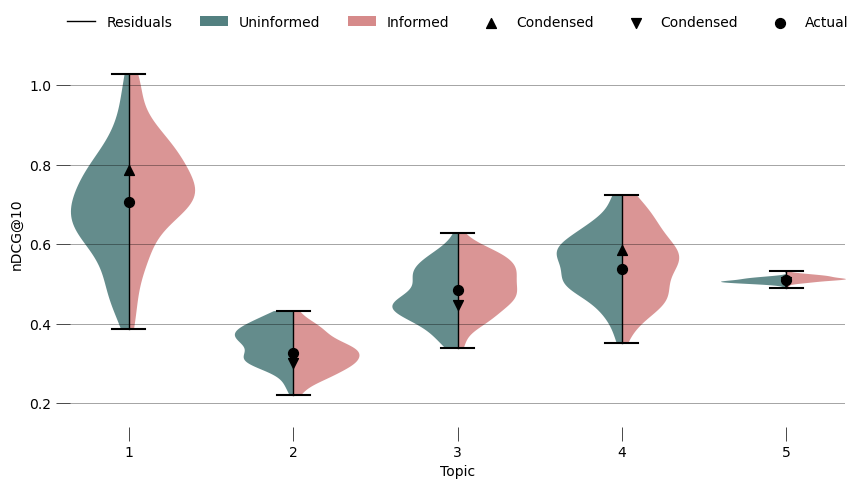

In [5]:
data = [simulate_topic(i) for i in range(5)]

with (
    aquarel
    .load_theme("boxy_light")
    .set_axes(bottom=False, top=False, left=False, right=False, ymargin=0.1)
    .set_ticks(draw_minor=False)
    .set_color(grid_color="k", tick_color="k")
):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.violinplot(
        ax=ax,
        data=get_distrib_data(data),
        x = "topic",
        y = "value",
        hue = "distribution",
        split=True,
        inner=None,
        linewidth=0,
        saturation=0.5,
        cut=0
    )
    for violin in zip(ax.collections):
        for face in violin:
            face.set_facecolor(to_rgba(face.get_facecolor(), alpha=0.9))

    total_topics = len(data)
    scalars = get_scalar_data(data)

    plt.scatter(
        scalars.loc[scalars["condensed"] > scalars["actual"], "topic_num"].values,
        scalars.loc[scalars["condensed"] > scalars["actual"], "condensed"].values,
        marker="^", color="k", label="Condensed", s=50
    )
    plt.scatter(
        scalars.loc[scalars["condensed"] <= scalars["actual"], "topic_num"].values,
        scalars.loc[scalars["condensed"] <= scalars["actual"], "condensed"].values,
        marker="v", color="k", label="Condensed", s=50
    )
    plt.scatter(
        scalars.loc[:, "topic_num"].values,
        scalars.loc[:, "actual"].values,
        marker="o", color="k", label="Actual", s=50
    )

    for index, row in scalars.iterrows():
        plt.plot((index, index), (row["min_resid"], row["max_resid"]), marker=None, color="k", label="Residuals", linewidth=1)
        plt.plot((index - 0.1, index + 0.1), (row["min_resid"], row["min_resid"]), marker=None, color="k")
        plt.plot((index - 0.1, index + 0.1), (row["max_resid"], row["max_resid"]), marker=None, color="k")

    handles, _ = ax.get_legend_handles_labels()

    plt.legend(handles=handles[-6:])
    ax.set_xlabel("Topic")
    ax.set_ylabel("nDCG@10")

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title=None, frameon=False,
)
plt.show()

In [6]:
#plt.savefig("output.pdf", dpi=300)